### Test the effect of 25 clinical indicators on POI prediction problems using machine learning

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, precision_score, accuracy_score,recall_score, f1_score,roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import roc_curve, auc

In [2]:
# load dataframes
case_cohort = pd.read_csv('../datasets/25-feature/cleaned_case.csv')
control_cohort = pd.read_csv('../datasets/25-feature/cleaned_control.csv')

In [3]:
case_cohort = case_cohort.astype('float32')
control_cohort = control_cohort.astype('float32')

In [4]:
# add labels and merge
case_cohort.insert(case_cohort.shape[1], 'label', 1)
control_cohort.insert(control_cohort.shape[1], 'label', 0)
merged = pd.concat([case_cohort, control_cohort])
merged

,eid,smoking status,sleep duration,sleeplessness,coffee intake,tea intake,moderate physical activity time spent,vigorous physical activity time spent,duration of moderate physical activity-pilot,duration of vigorous physical activity-pilot,...,qualifications,BMI,waist circumference,HDL-C,LDL-C,apolipoprotein B,treatment/medication code,ICD10,T2D,label
0,1004331.0,0.0,9.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,18.209801,65.0,-1.165660,-0.314136,0.925000,0.0,0.0,0.000000,1
1,1005087.0,0.0,7.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,31.288300,91.0,1.115530,-0.377054,1.082000,0.0,0.0,0.000000,1
2,1007659.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,31.840500,102.0,-0.464109,1.570590,1.113000,0.0,0.0,-0.395678,1
3,1014838.0,0.0,7.0,0.0,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,24.308001,70.0,0.150831,1.169080,1.209000,0.0,0.0,0.000000,1
4,1019851.0,0.0,9.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,25.179701,77.0,-0.638671,1.749310,0.835000,1.0,0.0,0.442098,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50582,6022151.0,0.0,8.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,27.765100,87.0,-1.058820,-0.942836,1.311000,0.0,0.0,-1.360960,0
50583,6022571.0,0.0,6.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,...,0.0,25.965099,74.0,1.139240,-0.222365,1.094000,0.0,0.0,0.000000,0
50584,6023181.0,0.0,6.0,1.0,4.0,4.0,0.0,0.0,0.0,0.0,...,0.0,23.815001,74.0,-0.896226,-0.271863,0.842000,0.0,0.0,-1.624070,0
50585,6023229.0,1.0,7.0,1.0,1.0,6.0,0.0,0.0,0.0,0.0,...,0.0,27.744101,88.0,0.022764,-0.077343,1.060069,0.0,0.0,0.000000,0


In [5]:
# shuffle and split dataset
dropped = merged.drop('eid',axis=1)
shuffled = shuffle(dropped)
train_data = shuffled[0:int(shuffled.shape[0]*0.9)]
test_data = shuffled[int(shuffled.shape[0]*0.9):]
print(train_data.shape[0])
print(test_data.shape[0])

55090
6122


In [6]:
# fetch values
nor_feature_train = train_data.drop('label',axis=1)
X_train = nor_feature_train.values
nor_feature_test = test_data.drop('label',axis=1)
X_test = nor_feature_test.values
Y_train = train_data['label'].values
Y_test = test_data['label'].values

In [9]:
# grid search
other_params = {'eta': 0.3, 'n_estimators': 420, 'gamma': 0, 'max_depth': 6, 'min_child_weight': 1,
                'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'reg_lambda': 1, 'reg_alpha': 0, 'scale_pos_weight':5,
                'seed': 33}

#cv_params = {'n_estimators': np.linspace(100, 1000, 10, dtype=int)} # 400
#cv_params = {'n_estimators': np.linspace(350, 450, 11, dtype=int)} # 420
cv_params = {'max_depth': np.linspace(1, 50, 10, dtype=int)} # 22

xgb_model = xgb.XGBClassifier(**other_params)
gs = GridSearchCV(xgb_model, cv_params, verbose=2, refit=True, cv=5, n_jobs=-1)
gs.fit(X_train, Y_train)
gs.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 22}

In [7]:
clf_xgb = xgb.XGBClassifier(n_estimators=420, scale_pos_weight=5, max_depth=22)
clf_xgb.fit(X_train,Y_train)

import pickle
with open('../models/25-feature/XGB.pickle', 'wb') as f:
    pickle.dump(clf_xgb, f)

confusion_matrix
 [[4865  185]
 [ 915  157]]
accuracy:0.8203201568114995
precision:0.4590643274853801
recall:0.146455223880597
f1-score:0.22206506364922204


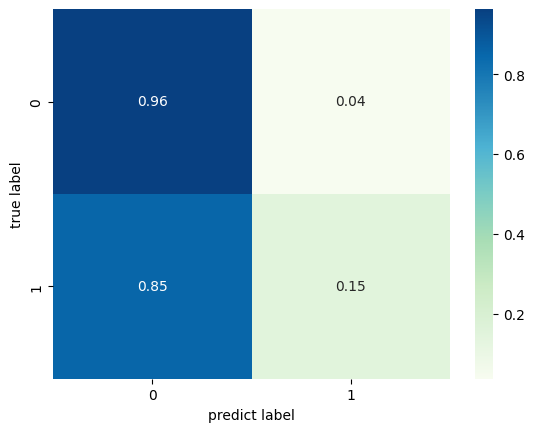

In [14]:
y_score = clf_xgb.predict(X_test)                                   
y_score_pro = clf_xgb.predict_proba(X_test) # (212, 2)
y_one_hot = to_categorical(Y_test)
y_score_one_hot = to_categorical(y_score)

obj1 = confusion_matrix(Y_test, y_score)
print('confusion_matrix\n', obj1)
print('accuracy:{}'.format(accuracy_score(Y_test, y_score)))
print('precision:{}'.format(precision_score(Y_test, y_score)))
print('recall:{}'.format(recall_score(Y_test, y_score)))
print('f1-score:{}'.format(f1_score(Y_test, y_score)))

# update confusion matrix
sum_all1 = obj1[0][0] + obj1[0][1]
sum_all2 = obj1[1][0] + obj1[1][1]
new_obj = np.array(
    [
        [float(obj1[0][0])/sum_all1, float(obj1[0][1])/sum_all1],
        [float(obj1[1][0])/sum_all2, float(obj1[1][1])/sum_all2]
    ]
)

import seaborn as sns
sns.heatmap(new_obj, fmt='.2f', cmap='GnBu', annot=True)
plt.ylabel("true label")
plt.xlabel("predict label")
plt.show()

AUC :  0.8598689998346802


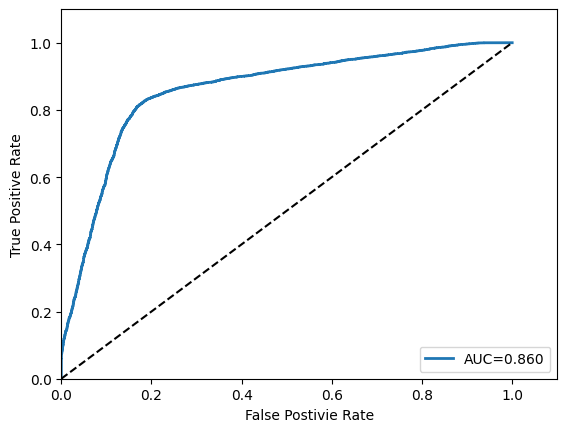

In [9]:
fpr_xgb, tpr_xgb, thresholds = roc_curve(y_one_hot.ravel(),y_score_pro.ravel())   
auc_xgb = auc(fpr_xgb, tpr_xgb)
print("AUC : ", auc_xgb)

plt.plot(fpr_xgb, tpr_xgb, linewidth = 2,label='AUC=%.3f' % auc_xgb)
plt.plot([0,1],[0,1], 'k--')
plt.axis([0,1.1,0,1.1])
plt.xlabel('False Postivie Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

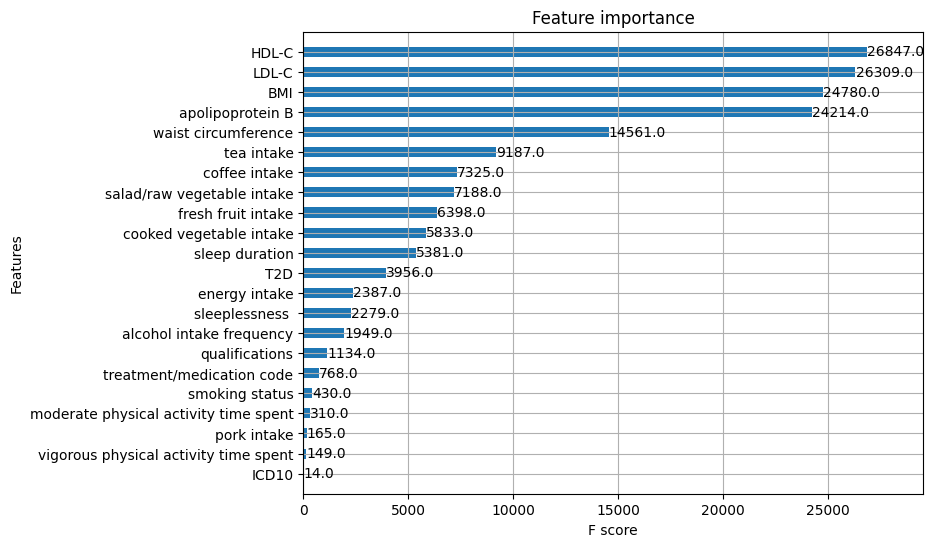

In [10]:
from xgboost import plot_importance
### plot feature importance
fig,ax = plt.subplots(figsize=(8,6))
feature_names = ['smoking status','sleep duration','sleeplessness ', 'coffee intake','tea intake','moderate physical activity time spent', 'vigorous physical activity time spent',
                'duration of moderate physical activity-pilot','duration of vigorous physical activity-pilot', 'alcohol intake frequency','energy intake',
                'salad/raw vegetable intake','fresh fruit intake','cooked vegetable intake','pork intake','qualifications','BMI','waist circumference',
                'HDL-C','LDL-C','apolipoprotein B','treatment/medication code','ICD10','T2D']
clf_xgb.get_booster().feature_names = feature_names
plot_importance(clf_xgb,
                height=0.5,
                ax=ax,
                max_num_features=64)
plt.show()       

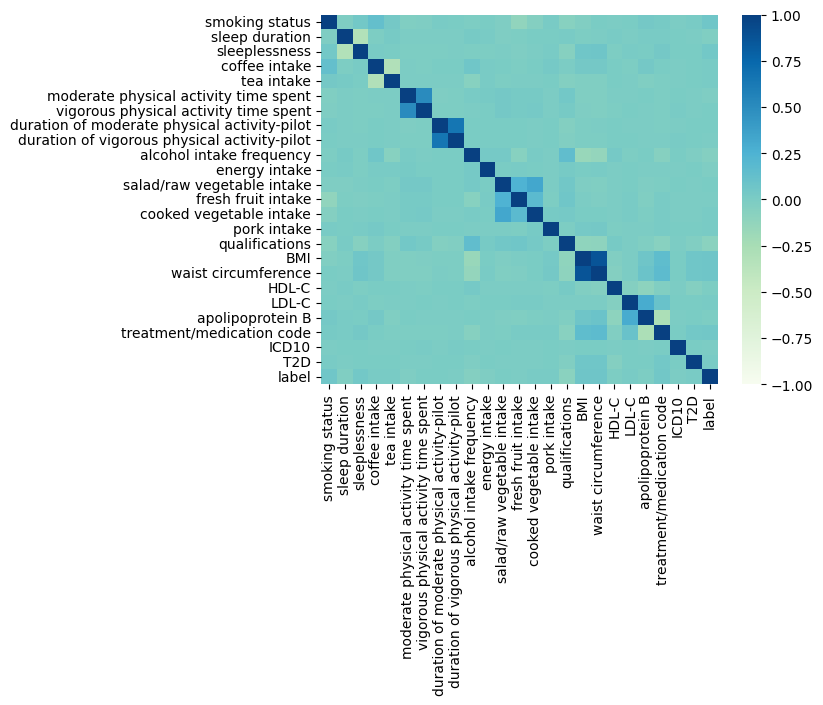

In [11]:
df_nan_corr = train_data.corr()
sns.heatmap(df_nan_corr, vmax=1, vmin=-1, center=0, cmap='GnBu')
plt.show()